## Importing Libraries

In [1]:
import math
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
from datetime import date
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from IPython.display import SVG

# Defaults
warnings.filterwarnings("ignore")  # specify to ignore warning messages

## Data Handling

In [2]:
def preprocess(df):
    df = df.drop(["Lat", "Long"], axis=1)
    df = df.groupby(["Country/Region"], as_index=False).sum()
    df.loc[-1] = df.sum()
    df.loc[-1, "Country/Region"] = "Worldwide"
    countries = [
        "US",
        "Germany",
        "Spain",
        "United Kingdom",
        "France",
        "India",
        "Iran",
        "Italy",
        "Russia",
        "Turkey",
        #         "Worldwide",
    ]
    df = df.loc[df["Country/Region"].isin(countries)]
    df.reset_index(drop=True, inplace=True)
    df = df.set_index("Country/Region")
    df.columns = pd.to_datetime(df.columns)
    df = df.T
    return df

In [3]:
confirmed_df = pd.read_csv(
    "../data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
)
confirmed_df = preprocess(confirmed_df)
deaths_df = pd.read_csv(
    "../data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
)
deaths_df = preprocess(deaths_df)
recovered_df = pd.read_csv(
    "../data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
)
recovered_df = preprocess(recovered_df)

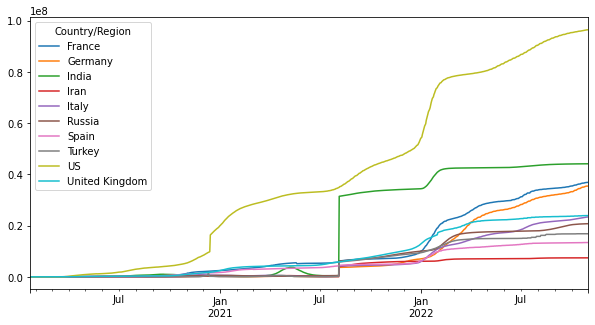

In [4]:
active_df = pd.DataFrame(confirmed_df - deaths_df - recovered_df)
active_df.plot(figsize=(10, 5))
plt.show()

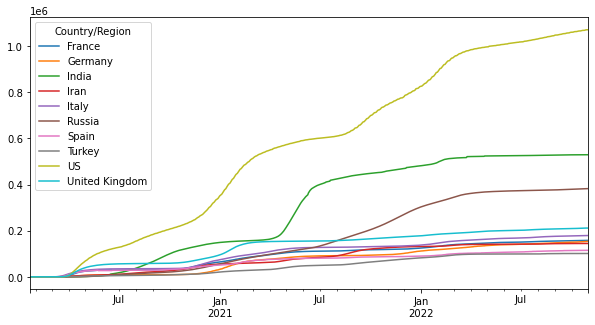

In [5]:
deaths_df.plot(figsize=(10, 5))
plt.show()

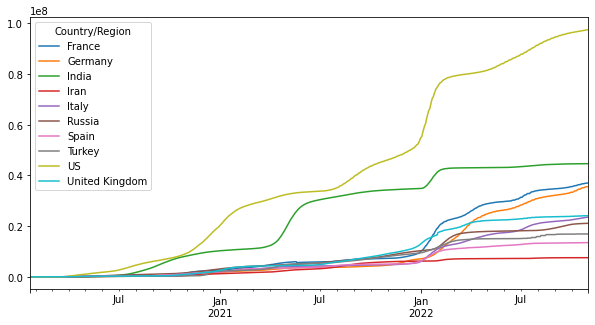

In [6]:
confirmed_df.plot(figsize=(10, 5))
plt.show()

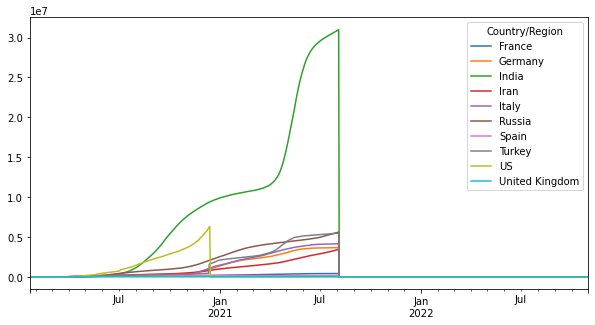

In [7]:
recovered_df.plot(figsize=(10, 5))
plt.show()

### Train test split

In [8]:
active_train = active_df[:"2021-04-04"]
active_test = active_df["2021-04-05":"2021-08-04"]
confirmed_train = confirmed_df[:"2021-04-04"]
confirmed_test = confirmed_df["2021-04-05":"2021-08-04"]

## Implementing ANN

In [9]:
df = confirmed_df
df.reset_index(level=0, inplace=True)
df.rename(columns={"index": "date"}, inplace=True)
df.reset_index(drop=True, inplace=True)
df

Country/Region,date,France,Germany,India,Iran,Italy,Russia,Spain,Turkey,US,United Kingdom
0,2020-01-22,0,0,0,0,0,0,0,0,1,0
1,2020-01-23,0,0,0,0,0,0,0,0,1,0
2,2020-01-24,2,0,0,0,0,0,0,0,2,0
3,2020-01-25,3,0,0,0,0,0,0,0,2,0
4,2020-01-26,3,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...
1009,2022-10-27,36964789,35523412,44649088,7557134,23475187,21097662,13488015,16919638,97418396,24122642
1010,2022-10-28,36990572,35571130,44650662,7557240,23504224,21105179,13511768,16919638,97448572,24122909
1011,2022-10-29,36990572,35571130,44652256,7557364,23531023,21112216,13511768,16919638,97457553,24122909
1012,2022-10-30,36990572,35571131,44653592,7557437,23531023,21118937,13511768,16919638,97460811,24122909


In [10]:
df = pd.DataFrame((df["India"].to_numpy()), columns={"cases"})
df = df.transform("sqrt")

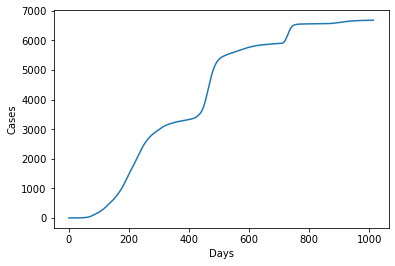

In [11]:
plt.plot(df)
plt.xlabel("Days")
plt.ylabel("Cases")
plt.show()

## Train-Test Split

In [12]:
test_df = df[-100:]
train_df = df[:-100]

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_df)

MinMaxScaler()

## Artificial Neural Networks

### Functions


In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [15]:
def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

In [16]:
def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(
        model_to_dot(
            model, show_shapes=show_shapes, show_layer_names=show_layer_names
        ).create(prog="dot", format="svg")
    )

In [17]:
def get_combinations(parameters):
    return list(itertools.product(*parameters))


In [18]:
def create_NN(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(Dense(int(hidden_nodes), input_dim=int(input_nodes)))
    model.add(Dense(int(output_nodes)))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

### Train Model

In [19]:
def train_model(model, X_train, y_train, epochs, batch_size):
    model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True
    )
    return model

In [20]:
def reshape_arrays(X_train, y_train):
    X_train = np.array(X_train)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

## Feed Forward ANN

### Data Preprocessing

In [21]:
def preprocess_FNN(data, look_back):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data.shape[0] - look_back):
        x = data[i : look_back + i][::-1]
        y = data[look_back + i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i + 1 : look_back + i + 1][::-1]
    return X_train, y_train, input_seq_for_test

### Feed Forward ANN Forecast

In [22]:
def forecast_FNN(model, input_sequence, future_steps):
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0] = np.append(forecasted_value, input_sequence[0][:-1])
    return forecasted_values

### Feed Forward Network

In [23]:
def FNN(
    data,
    look_back,
    hidden_nodes,
    output_nodes,
    epochs,
    batch_size,
    future_steps,
    scaler,
):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_FNN = preprocess_FNN(data, look_back)
    X_train, y_train = reshape_arrays(X_train, y_train)

    model_FNN = create_NN(
        input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes
    )
    model_FNN = train_model(model_FNN, X_train, y_train, epochs, batch_size)

    input_seq_for_test_FNN = np.reshape(
        input_seq_for_test_FNN, (1, len(input_seq_for_test_FNN))
    )
    forecasted_values_FNN = forecast_FNN(
        model_FNN, input_sequence=input_seq_for_test_FNN, future_steps=future_steps
    )

    forecasted_values_FNN = list(scaler.inverse_transform([forecasted_values_FNN])[0])

    return model_FNN, forecasted_values_FNN

### FNN scores

In [24]:
def get_accuracies_FNN(train_data, test_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_FNN = []
    iterator = 0
    print("FNN - Number of combinations: " + str(len(combination_of_params)))

    for param in combination_of_params:
        if (iterator + 1) != len(combination_of_params):
            print(iterator + 1, end=" -> ")
        else:
            print(iterator + 1)
        iterator = iterator + 1

        look_back = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]

        model_FNN, forecasted_values_FNN = FNN(
            train_data,
            look_back,
            hidden_nodes,
            output_nodes,
            epochs,
            batch_size,
            future_steps,
            scaler,
        )

        y_true = test_data.iloc[:future_steps]
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_FNN)

        info = list(param) + [mse, mae, rmse] + forecasted_values_FNN
        information_FNN.append(info)

    information_FNN_df = pd.DataFrame(information_FNN)
    indexes = [str(i) for i in list(range(1, future_steps + 1))]
    information_FNN_df.columns = [
        "look_back",
        "hidden_nodes",
        "output_nodes",
        "epochs",
        "batch_size",
        "future_steps",
        "MSE",
        "MAE",
        "RMSE",
    ] + indexes
    return information_FNN_df

### Analyze the test data and forecasted data

In [25]:
def analyze_results(data_frame, test_data):
    optimized_params = data_frame.iloc[data_frame.RMSE.argmin()]
    future_steps = optimized_params.future_steps
    forecast_values = optimized_params[-1 * int(future_steps) :]
    y_true = test_data.iloc[: int(future_steps)]
    forecast_values.index = y_true.index

    print("\n=== Best parameters of FNN ===\n")
    model = create_NN(
        optimized_params.look_back,
        optimized_params.hidden_nodes,
        optimized_params.output_nodes,
    )

    print("Input nodes(p): " + str(optimized_params.look_back))
    print("Hidden nodes: " + str(optimized_params.hidden_nodes))
    print("Output nodes: " + str(optimized_params.output_nodes))
    print("Number of epochs: " + str(optimized_params.epochs))
    print("Batch size: " + str(optimized_params.batch_size))
    print("Number of future steps forecasted: " + str(optimized_params.future_steps))
    print("Mean Squared Error(MSE): " + str(optimized_params.MSE))
    print("Mean Absolute Error(MAE): " + str(optimized_params.MAE))
    print("Root Mean Squared Error(RMSE): " + str(optimized_params.RMSE))
    print("\n\n")

    plt.figure(figsize=(10, 5))
    plt.plot(y_true, color="green", label="Actual values")
    plt.plot(forecast_values, color="red", label="Forecasted values")
    plt.xlabel("No. of Days")
    plt.ylabel("No. of COVID Cases (x1000)")
    plt.legend(loc="best")
    plt.title("Comparison: Actual vs Forecasted")
    plt.savefig("../images/ANNprediction.jpg")

    return optimized_params

### Compare Results of above algorithms

In [26]:
def calculate_RMSE(
    train_data,
    test_data,
    scaler,
    parameters_FNN,
    future_steps,
):

    information_FNN_df = get_accuracies_FNN(
        train_data, test_data, parameters_FNN, scaler
    )
    optimized_params_FNN = analyze_results(information_FNN_df, test_data)

    RMSE_info = optimized_params_FNN.RMSE

    return RMSE_info, optimized_params_FNN

### Number of Future steps to be forecasted

In [27]:
future_steps = 100

In [28]:
parameters_FNN = [
    [1, 2, 3, 6, 8, 10, 12],
    [3, 4, 5, 6],
    [1],
    [500],
    [20],
    [future_steps],
]

FNN - Number of combinations: 28
1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 60ms/step
28
1/1 [==============================] - 0s 49ms/step

=== Best parameters of FNN ===

Input nodes(p): 2.0
Hidden nodes: 6.0
Output nodes: 1.0
Number of epochs: 500.0
Batch size: 20.0
Number of future steps forecasted: 100.0
Mean Squared Error(MSE): 2014.718
Mean Absolute Error(MAE): 41.76
Root Mean Squared Error(RMSE): 44.886





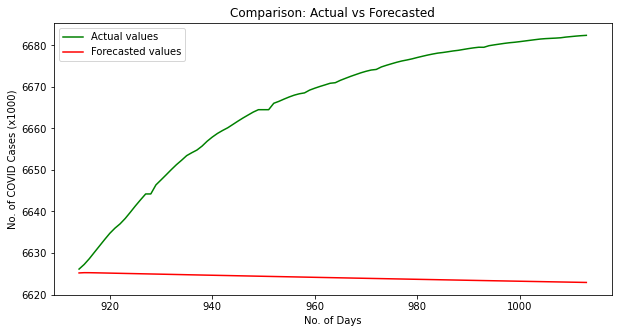

In [29]:
RMSE_info, optimised_params = calculate_RMSE(
    train_df, test_df, scaler, parameters_FNN, future_steps
)